In [2]:
!pip install caer

     |████████████████████████████████| 809 kB 917 kB/s            
     |████████████████████████████████| 14.0 MB 42.1 MB/s            


In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.models import Model, load_model
from skimage.morphology import label
import pickle
import tensorflow.keras.backend as K

from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import random
from skimage.io import imread, imshow, imread_collection, concatenate_images
from matplotlib import pyplot as plt
import gc
import shutil as sh

import caer 
seed = 56

In [4]:
IMAGE_HEIGHT = IMAGE_WIDTH = 256
NUM_CHANNELS = 3
IMG_SIZE = (256, 256)

EPOCHS = 100
LEARNING_RATE = 0.0001
BATCH_SIZE = 16

# Defining Custom Loss functions and accuracy Metric.

In [5]:
#Source: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
from keras import backend as K

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [6]:
train = caer.path.list_images("/kaggle/input/massachusetts-roads-utoronto-trainvaltest-jpg/MassachusettsRoads/train/roads", recursive=True, use_fullpath=True)
val = caer.path.list_images("/kaggle/input/massachusetts-roads-utoronto-trainvaltest-jpg/MassachusettsRoads/val/roads", recursive=True, use_fullpath=True)
test = caer.path.list_images("/kaggle/input/massachusetts-roads-utoronto-trainvaltest-jpg/MassachusettsRoads/test/roads", recursive=True, use_fullpath=True)
 
# Comment the following only if applying data augmentation (to have separate validation set)
for i in val:
    train.append(i)

del val
gc.collect()

print(len(train))
# print(len(val))
print(len(test))

[INFO] 880 files found in 0.2368316650390625s
[INFO] 220 files found in 0.048752546310424805s
[INFO] 71 files found in 0.011965036392211914s
1100
71


In [7]:
# Train
__train_roads = []
__train_masks = []
count = 0
for i in train:
    road_arr = caer.imread(i, target_size=IMG_SIZE)
    road = np.array(road_arr)
    arr = caer.imread(i.replace("/roads/", "/masks/"), target_size=IMG_SIZE)
    gray = caer.rgb2gray(arr)
    mask_arr = np.array(gray)
    mask = np.expand_dims(mask_arr, -1)
#     mask = mask_arr
    
    __train_roads.append(road)
    __train_masks.append(mask)
    
    count += 1
    if count % 100 == 0:
        print(count)
    
    del arr
    del road_arr
    del mask_arr
    gc.collect()

train_roads = np.array(__train_roads)
train_masks = np.array(__train_masks)

del __train_roads
del __train_masks

print("TRAIN SET: ")
print(train_roads.shape)
print(train_masks.shape)

100
200
300
400
500
600
700
800
900
1000
1100
TRAIN SET: 
(1100, 256, 256, 3)
(1100, 256, 256, 1)


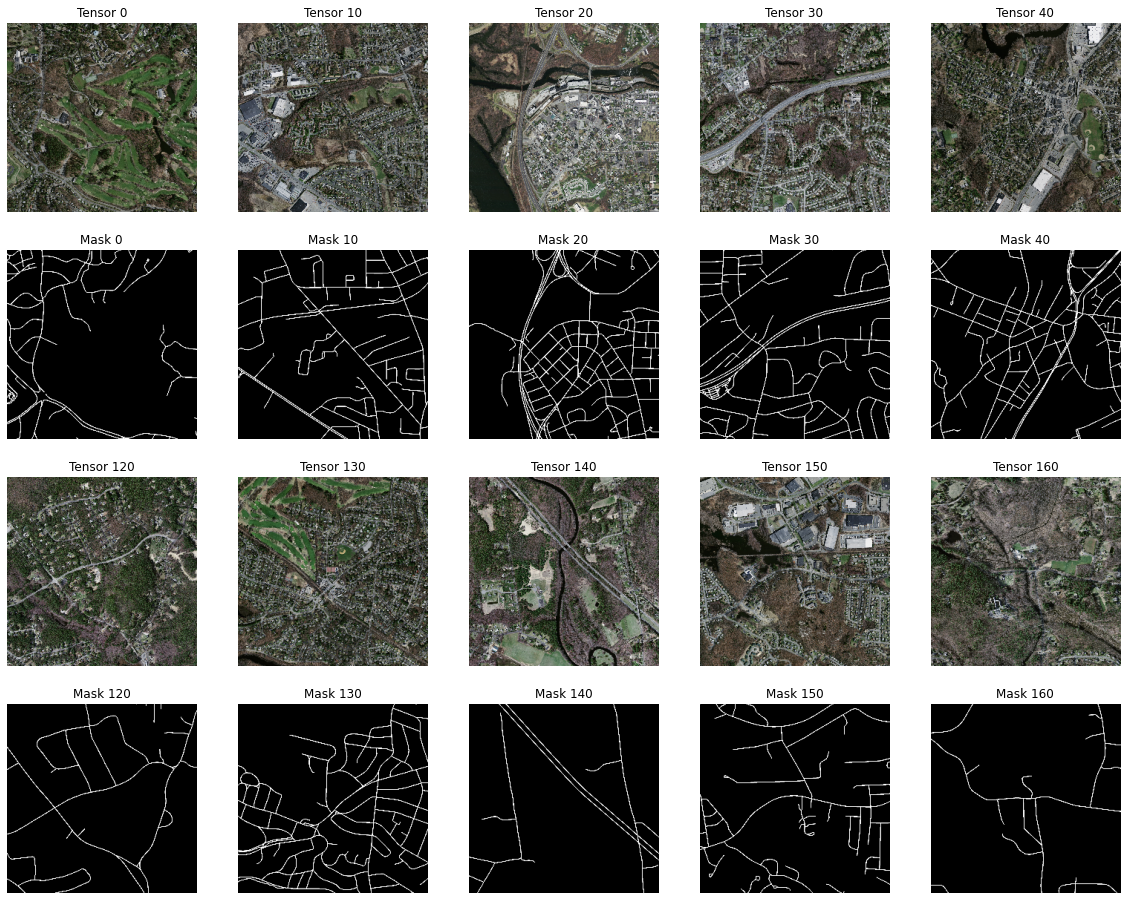

In [8]:
plt.figure(figsize=(20, 16))
x, y = 5, 2
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*120 + j*10
        plt.imshow(train_roads[pos])
        plt.title(f"Tensor {pos}")
        plt.axis('off')
        
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        plt.imshow(train_masks[pos], cmap="gray")
        plt.title(f'Mask {pos}')
        plt.axis('off')
        
plt.show()

In [9]:
train_roads = train_roads.astype("float32")
train_masks = train_masks.astype("float32")

mean = np.mean(train_roads)
std = np.std(train_roads)

print(f"Mean = {mean}")
print(f"Std =   {std}")

train_roads -= mean
train_roads /= std
train_masks /= 255 # scale to [0, 1]

Mean = 105.55280303955078
Std =   72.74275207519531


In [10]:
# Test
__test_roads = []
__test_masks = []
count = 0
for i in test:
    road_arr = caer.imread(i, target_size=IMG_SIZE)
    road = np.array(road_arr)
    arr = caer.imread(i.replace("/roads/", "/masks/"), target_size=IMG_SIZE)
    gray = caer.rgb2gray(arr)
    mask_arr = np.array(gray)
    mask = np.expand_dims(mask_arr, -1)
    
    __test_roads.append(road)
    __test_masks.append(mask)
    
    count += 1
    if count % 100 == 0:
        print(count)
    
    del arr
    del road_arr
    del mask_arr
    gc.collect()

test_roads = np.array(__test_roads).astype("float32")
test_masks = np.array(__test_masks).astype("float32")

test_roads -= mean
test_masks /= std

del __test_roads
del __test_masks

print("TEST SET: ")
print(test_roads.shape)
print(test_masks.shape)

TEST SET: 
(71, 256, 256, 3)
(71, 256, 256, 1)


# Data Augmentation

In [13]:
# # Val
# __val_roads = []
# __val_masks = []
# count = 0
# for i in val:
#     road_arr = caer.imread(i, target_size=IMG_SIZE)
#     road = np.array(road_arr)
#     arr = caer.imread(i.replace("/roads/", "/masks/"), target_size=IMG_SIZE)
#     gray = caer.rgb2gray(arr)
#     mask_arr = np.array(gray)
#     mask = np.expand_dims(mask_arr, -1)
# #     mask = mask_arr
    
#     __val_roads.append(road)
#     __val_masks.append(mask)
    
#     count += 1
#     if count % 100 == 0:
#         print(count)
    
#     del arr
#     del road_arr
#     del mask_arr
#     gc.collect()

# val_roads = np.array(__val_roads)
# val_masks = np.array(__val_masks)

# del __val_roads
# del __val_masks

# print("VAL SET: ")
# print(val_roads.shape)
# print(val_masks.shape)

In [14]:
# from keras.preprocessing import image

# # Creating the training Image and Mask generator
# roads_datagen = image.ImageDataGenerator(
#                             featurewise_center=True,
#                             samplewise_center=True,
#                             featurewise_std_normalization=True,
#                             samplewise_std_normalization=True,
# #                             zca_whitening=True,
#                             # zca_epsilon=1e-06,
#                             rotation_range=10,
#                             width_shift_range=0.3,
#                             height_shift_range=0.2,
#                             shear_range=0.3,
#                             zoom_range=0.2,
# #                             channel_shift_range=0.1,
#                             cval=0.1,
#                             horizontal_flip=True,
#                             vertical_flip=True,
#                             rescale=0.1,
#                         )

# mask_datagen = image.ImageDataGenerator(
#                             featurewise_center=True,
#                             samplewise_center=True,
#                             featurewise_std_normalization=True,
#                             samplewise_std_normalization=True,
# #                             zca_whitening=True,
#                             # zca_epsilon=1e-06,
#                             rotation_range=10,
#                             width_shift_range=0.3,
#                             height_shift_range=0.2,
#                             shear_range=0.3,
#                             zoom_range=0.2,
# #                             channel_shift_range=0.1,
#                             cval=0.1,
#                             horizontal_flip=True,
#                             vertical_flip=True,
#                             rescale=0.1,
#                         )

# # Keep the same seed for image and mask generators so they fit together

# roads_datagen.fit(train_roads, augment=True, seed=seed)
# mask_datagen.fit(train_masks, augment=True, seed=seed)

# x = roads_datagen.flow(train_roads, batch_size=BATCH_SIZE,shuffle=True, seed=seed)
# y = mask_datagen.flow(train_masks, batch_size=BATCH_SIZE,shuffle=True, seed=seed)


# # Creating the validation Image and Mask generator
# val_roads_datagen = image.ImageDataGenerator()
# val_mask_datagen = image.ImageDataGenerator()

# val_roads_datagen.fit(val_roads, augment=True, seed=seed)
# val_mask_datagen.fit(val_masks, augment=True, seed=seed)

# x_val = val_roads_datagen.flow(val_roads, batch_size=BATCH_SIZE, shuffle=True, seed=seed)
# y_val = val_mask_datagen.flow(val_masks, batch_size=BATCH_SIZE, shuffle=True, seed=seed)

In [15]:
# imshow(x.next()[0].astype(np.uint8))
# plt.show()
# imshow(np.squeeze(y.next()[0].astype(np.uint8)))
# plt.show()
# imshow(x_val.next()[0].astype(np.uint8))
# plt.show()
# imshow(np.squeeze(y_val.next()[0].astype(np.uint8)))
# plt.show()

In [16]:
# #creating a training and validation generator that generate masks and images
# train_generator = zip(x, y)
# val_generator = zip(x_val, y_val)

# Defining Our Model

In [17]:
from keras.models import Model, load_model
import tensorflow as tf
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import optimizers
from keras.models import *
from keras.layers import *
from tensorflow.keras.optimizers import *
from keras.layers import BatchNormalization
from tensorflow.keras.metrics import MeanIoU
import keras

In [18]:
def unet(input_size = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

#     model.compile(optimier = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

In [19]:
model = unet()
model.summary()

2022-01-31 11:48:50.649140: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 11:48:50.760029: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 11:48:50.760815: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 11:48:50.761979: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [20]:
# from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

# tbc=TensorBoardColab()

In [21]:
model_path = "mass_roads_unet.h5"
checkpointer = ModelCheckpoint(
                        model_path,
                         monitor="val_loss",
                         mode="min",
                         save_best_only = True,
                         verbose=1
                )

earlystopper = EarlyStopping(
                      monitor = 'val_loss', 
                      min_delta = 0, 
                      patience = 10,
                      verbose = 1,
                      restore_best_weights = True
                )

lr_reducer = ReduceLROnPlateau(
                       monitor='val_loss',
                       factor=0.1,
                       patience=4,
                       verbose=1,
                       epsilon=1e-4
                )

In [22]:
opt = tf.keras.optimizers.Adam(LEARNING_RATE)
model.compile(
      optimizer=opt,
      loss=soft_dice_loss,
      metrics=[iou_coef, "accuracy"])

# model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = [iou_coef, 'accuracy'])

In [23]:
history = model.fit(train_roads,
                    train_masks,
                    validation_split = 0.1,
                    epochs=EPOCHS,
                    shuffle=True,
                    batch_size = BATCH_SIZE,
                    callbacks = [checkpointer, earlystopper, lr_reducer]
                )

### Uncomment only if using Data Augmentation
# history = model.fit_generator(
#                     train_generator,
#                     validation_data=val_generator,
#                     validation_steps=10,
#                     epochs=EPOCHS,
# #                     shuffle=True,
#                     steps_per_epoch=len(train_roads) // BATCH_SIZE,
#                     callbacks = [checkpointer, earlystopper, lr_reducer]
# )

2022-01-31 11:48:53.806184: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 778567680 exceeds 10% of free system memory.
2022-01-31 11:48:54.880251: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 778567680 exceeds 10% of free system memory.
2022-01-31 11:48:55.650266: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-01-31 11:48:57.809869: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


62/62 [==============================] - 55s 641ms/step - loss: 0.8359 - iou_coef: 0.0761 - accuracy: 0.8630 - val_loss: 0.7969 - val_iou_coef: 0.0925 - val_accuracy: 0.8902

Epoch 00001: val_loss improved from inf to 0.79687, saving model to mass_roads_unet.h5
Epoch 2/100
62/62 [==============================] - 32s 510ms/step - loss: 0.7904 - iou_coef: 0.0998 - accuracy: 0.8713 - val_loss: 0.7707 - val_iou_coef: 0.1098 - val_accuracy: 0.8790

Epoch 00002: val_loss improved from 0.79687 to 0.77067, saving model to mass_roads_unet.h5
Epoch 3/100
62/62 [==============================] - 32s 509ms/step - loss: 0.7672 - iou_coef: 0.1149 - accuracy: 0.8779 - val_loss: 0.7533 - val_iou_coef: 0.1234 - val_accuracy: 0.8732

Epoch 00003: val_loss improved from 0.77067 to 0.75327, saving model to mass_roads_unet.h5
Epoch 4/100
62/62 [==============================] - 32s 509ms/step - loss: 0.7452 - iou_coef: 0.1303 - accuracy: 0.8860 - val_loss: 0.7278 - val_iou_coef: 0.1386 - val_accuracy: 0.8

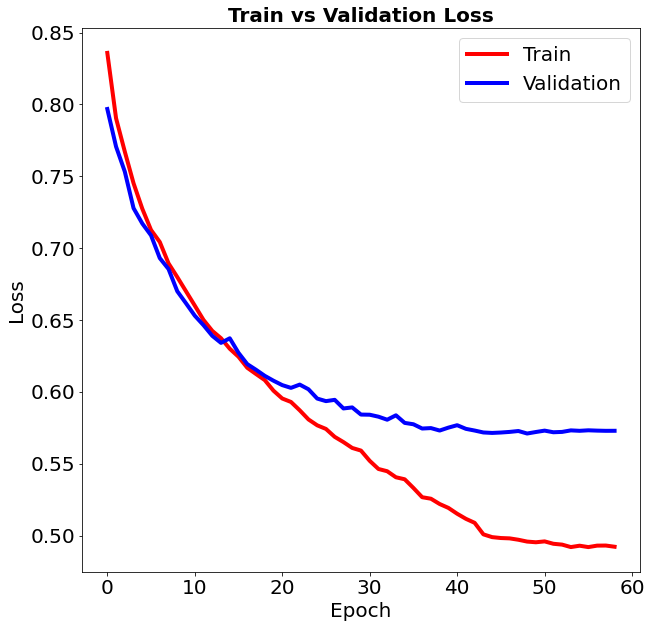

In [24]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'], linewidth=4, color='r')                   #visualising training and validation loss curves
plt.plot(history.history['val_loss'], linewidth=4, color='b')
plt.title('Train vs Validation Loss', fontsize=20, fontweight="bold")
plt.ylabel('Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("loss.jpg")
plt.show()

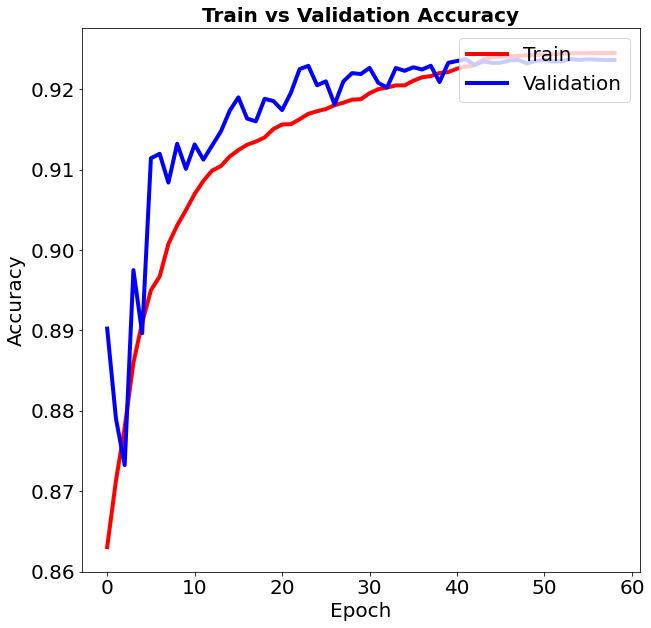

In [25]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'], linewidth=4, color='r')                   #visualising training and validation loss curves
plt.plot(history.history['val_accuracy'], linewidth=4, color='b')
plt.title('Train vs Validation Accuracy', fontsize=20, fontweight="bold")
plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("accuracy.jpg")
plt.show()

In [26]:
from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = model.to_json()

with open("mass_roads_unet.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("mass_roads_unet_weights.h5")

# Testing the model

In [27]:
model = load_model("./mass_roads_unet.h5", custom_objects={'soft_dice_loss': soft_dice_loss, 'iou_coef': iou_coef})
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [28]:
model.evaluate(test_roads, test_masks)

3/3 [==============================] - 14s 2s/step - loss: 0.4012 - iou_coef: 0.4335 - accuracy: 0.9006


[0.40122613310813904, 0.43348801136016846, 0.9005943536758423]

In [29]:
predictions = model.predict(test_roads, verbose=1)

3/3 [==============================] - 1s 285ms/step


In [30]:
thresh_val = 0.1
prediction_threshold = (predictions > thresh_val).astype(np.uint8)

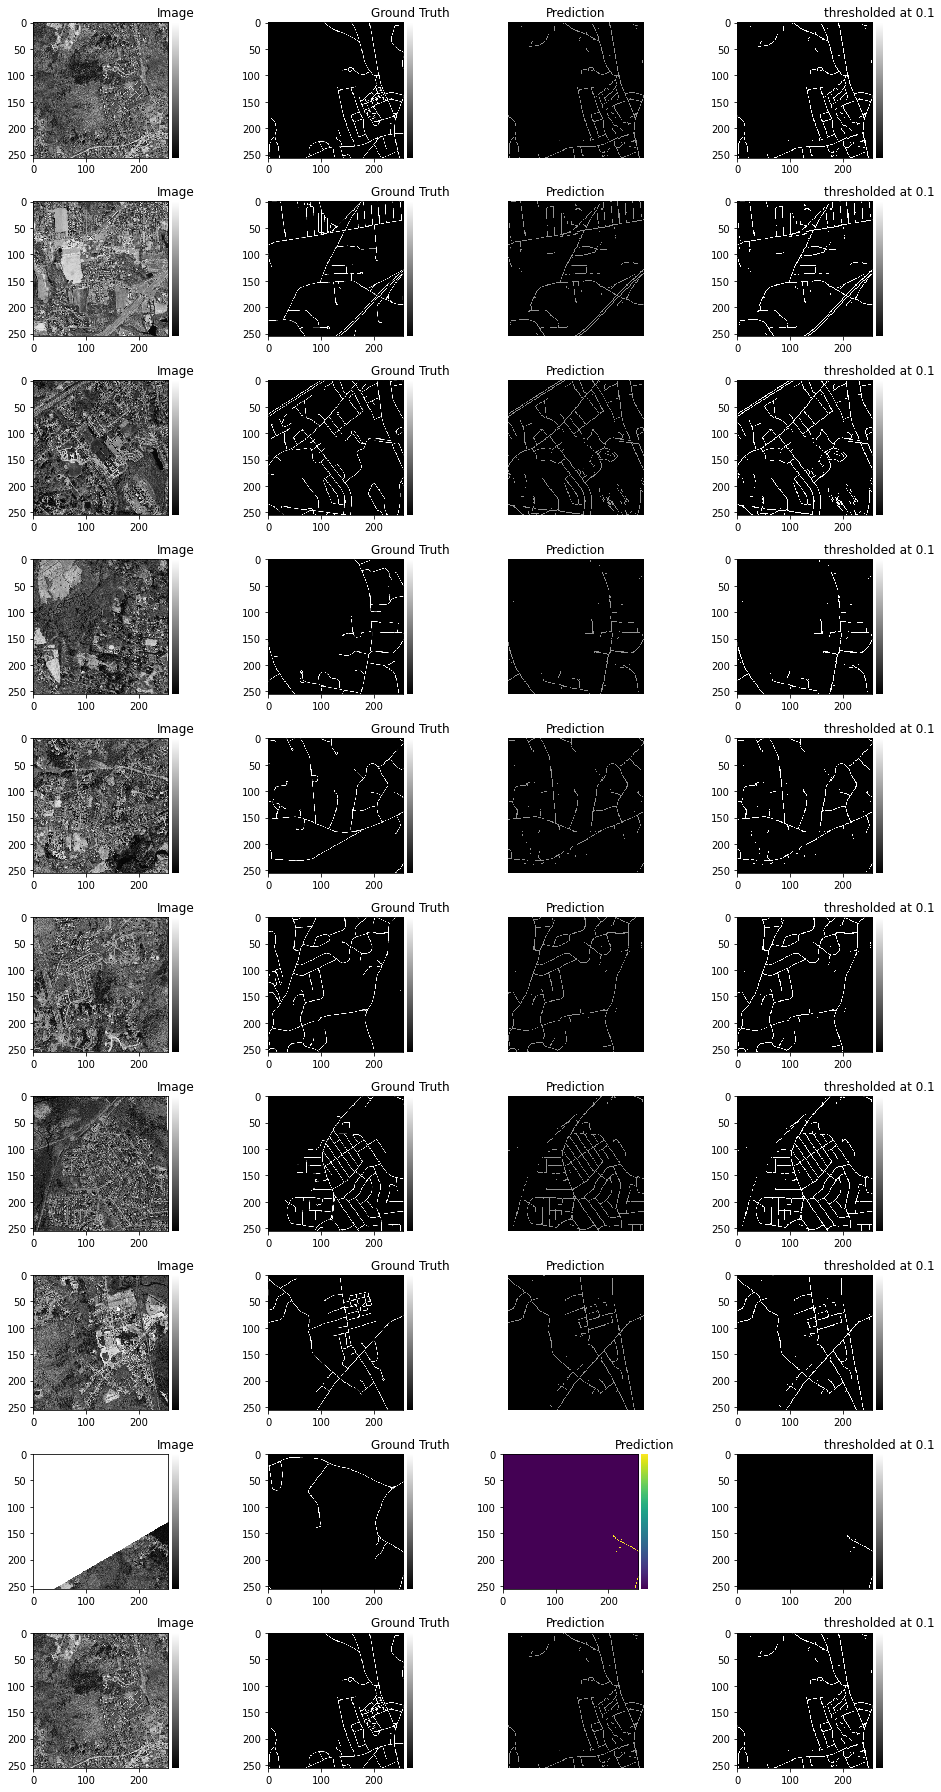

In [31]:
ix = random.randint(0, len(predictions))
num_samples = 10

f = plt.figure(figsize = (15, 25))
for i in range(1, num_samples*4, 4):
    ix = random.randint(0, len(predictions))

    f.add_subplot(num_samples, 4, i)
    img = test_roads[ix][:,:,0]
    
    img += mean
    img *= std
    imshow(img, cmap="gray")

    plt.title("Image")
    plt.axis('off')

    f.add_subplot(num_samples, 4, i+1)
    imshow(np.squeeze(test_masks[ix][:,:,0]), cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    f.add_subplot(num_samples, 4, i+2)
    imshow(np.squeeze(predictions[ix][:,:,0]))
    plt.title("Prediction")
    plt.axis('off')

    f.add_subplot(num_samples, 4, i+3)
    imshow(np.squeeze(prediction_threshold[ix][:,:,0]), cmap="gray")
    plt.title("thresholded at {}".format(thresh_val))
    plt.axis('off')

plt.show()